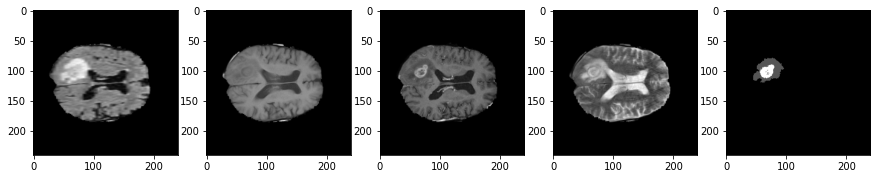

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os

img_PATH = '/home/sarucrcv/projects/brats/train_pkl_all/BRATS_002/BRATS_002_86.npy'


p = np.load(img_PATH, allow_pickle = True)
img = (p[0] - 0) / (p[0].max() + 0.001)
if img.max()!=0:
    plt.figure(figsize= (15,15))
    plt.subplot(1,5,1)
    plt.imshow(img[...,0], cmap='gray')
    plt.subplot(1,5,2)
    plt.imshow(img[...,1], cmap='gray')
    plt.subplot(1,5,3)
    plt.imshow(img[...,2], cmap='gray')
    plt.subplot(1,5,4)
    plt.imshow(img[...,3], cmap='gray')
    plt.subplot(1,5,5)
    plt.imshow(p[1], cmap='gray')




In [2]:
def visualize(img, label):
    img = img.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    print(np.unique(label))
    plt.figure(figsize= (15,15))
    plt.subplot(1,5,1)
    plt.imshow(img[...,0], cmap='gray')
    plt.subplot(1,5,2)
    plt.imshow(img[...,1], cmap='gray')
    plt.subplot(1,5,3)
    plt.imshow(img[...,2], cmap='gray')
    plt.subplot(1,5,4)
    plt.imshow(img[...,3], cmap='gray')
    plt.subplot(1,5,5)
    plt.imshow(label, cmap='gray')

In [3]:
p[1].dtype

dtype('uint8')

In [4]:
p[1].max()

3

In [12]:
import numpy as np
import albumentations as A
import cv2
import torch
from torch.utils.data import DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from glob import glob


class TumorDataset(Dataset):
    def __init__(self, pickle_path_root = '/home/sarucrcv/projects/brats/train_pkl_all/', transforms=None ):
        """
        pickle_path_root = /home/sarucrcv/projects/brats/train_pkl_all
        """
        self.data = glob(pickle_path_root+"*/*.npy")[:3000]
        self.transforms = transforms
        self.ImageMaskTransforms = A.Compose([
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5)
            ]),
            A.RandomRotate90(p=0.5)

        ])
        self.ImageTransforms = A.Compose([
            A.RandomBrightnessContrast(p=0.8)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ix):
        d = np.load(self.data[ix], allow_pickle=True)
        img = d[0]/(np.max(d[0])+0.0001)
        label = d[1]
        return img, label
    
def collate_fn(train, batch):
        _imgs, _masks = list(zip(*batch))
        imgs, masks = [], []
        if train.transforms:
            for i in len(_imgs):
                augmented = train.ImageMaskTransforms(image = _imgs[i],mask =  _masks[i])
                imgs.append(torch.Tensor(augmented[0]).unsqueeze(0))
                masks.append(torch.Tensor(augmented[1]).unsqueeze(0))
            imgs = torch.cat(imgs, dim=0).float().to(device)
            masks = torch.cat(masks, dim=0).float().to(device)
            return imgs, masks
        else:
            return _imgs, _masks
                # augmented2 = self.ImageTransforms(imgs[i])
                # imgs[i] = augmented2[0]
            



In [6]:
train = TumorDataset()

In [7]:
len(train)

10000

[0. 1. 2. 3.]


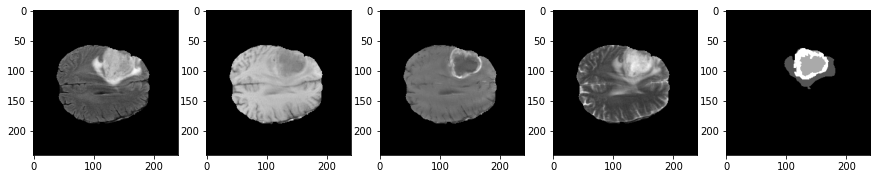

In [8]:
img, l = train[3]
img, l = torch.Tensor(img).to(device), torch.Tensor(l).to(device)
visualize(img, l)

In [9]:
!nvidia-smi

Thu Apr 14 21:49:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.54       Driver Version: 510.54       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  On   | 00000000:02:00.0 Off |                  N/A |
| 23%   42C    P2    56W / 250W |    631MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
trainLoader = DataLoader(train, batch_size = 4, shuffle=True)

In [13]:
val = TumorDataset(pickle_path_root = '/home/sarucrcv/projects/brats/val_pkl_all/')
len(val)

3000

In [14]:
valLoader = DataLoader(val, batch_size=4, shuffle = True)
len(valLoader)

750

In [15]:
len(trainLoader)

2500

In [16]:
for i, batch in enumerate(trainLoader):
    imgs, labels = batch
    if torch.max(labels[i]) == 3:
        visualize(imgs[3], labels[3])
        break

IndexError: index 4 is out of bounds for dimension 0 with size 4

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.softmax(logits, dim=1)


In [23]:
model = UNet(4, 4).to(device)

In [24]:
from torchsummary import summary
summary(model, (4, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           2,304
       BatchNorm2d-2         [-1, 64, 240, 240]             128
              ReLU-3         [-1, 64, 240, 240]               0
            Conv2d-4         [-1, 64, 240, 240]          36,864
       BatchNorm2d-5         [-1, 64, 240, 240]             128
              ReLU-6         [-1, 64, 240, 240]               0
        DoubleConv-7         [-1, 64, 240, 240]               0
         MaxPool2d-8         [-1, 64, 120, 120]               0
            Conv2d-9        [-1, 128, 120, 120]          73,728
      BatchNorm2d-10        [-1, 128, 120, 120]             256
             ReLU-11        [-1, 128, 120, 120]               0
           Conv2d-12        [-1, 128, 120, 120]         147,456
      BatchNorm2d-13        [-1, 128, 120, 120]             256
             ReLU-14        [-1, 128, 1

In [19]:
import torch.nn as nn
import torch.functional as F
from hausdorff import hausdorff_distance

def Dice(output, target, eps=1e-5):
    target = target.float()
    num = 2 * (output * target).sum()
    den = output.sum() + target.sum() + eps
    return 1.0 - num/den

def Hausdoff(output, target, eps=1e-5):
    return hausdorff_distance(output, target)

class softmax_dice(nn.Module):
    '''
    The dice loss for using softmax activation function
    :param output: (b, num_class, d, h, w)
    :param target: (b, d, h, w)
    :return: softmax dice loss
    '''
    def __init__(self):
        super(softmax_dice, self).__init__()
        
    def forward(self, output, target):
        target[target == 4] = 3 
        output = output.cuda()
        target = target.cuda()
        loss0 = Dice(output[:, 0, ...], (target == 0).float())
        loss1 = Dice(output[:, 1, ...], (target == 1).float())
        loss2 = Dice(output[:, 2, ...], (target == 2).float())
        loss3 = Dice(output[:, 3, ...], (target == 3).float())
        loss0 = Dice(output[:, 0, ...], (target == 0).float())
        loss1 = Dice(output[:, 1, ...], (target == 1).float())
        loss2 = Dice(output[:, 2, ...], (target == 2).float())
        loss3 = Dice(output[:, 3, ...], (target == 3).float())
        return loss1 + loss2 + loss3 + loss0, 1- loss0.data, 1-loss1.data, 1-loss2.data, 1-loss3.data
    
def log(mode, epoch, i, loss, l0, l1, l2, l3):
    loss, l0, l1, l2, l3 = [round(j/i,3) for j in [loss, l0, l1, l2, l3]]
    ET = l3
    TC = round((l1 + l2)/2,3)
    WT = round((l1 + l2 + l3)/3,3)
    print(f"{mode} | Epoch: {epoch+1} | Iter: {i+1} Overall Loss: {loss} | BackGround: {l0} | ET : {ET} | TC : {TC} | WT : {WT}")

In [20]:
import numpy

In [15]:

o = numpy.random.random((240,240))*10
t = numpy.random.random((240,240))*20
Hausdoff(o, t)

128.9618737554933

In [26]:
print(f"Train Loader {len(trainLoader)}")
print(f"Val Loader {len(valLoader)}")
model = UNet(4, 4).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = softmax_dice()
nEpochs = 10
log_interval = 1000
training_res = []
val_res = []

Train Loader 2500
Val Loader 750


In [27]:
from tqdm import tqdm

In [33]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    images, targets = data
    images = images.to(device)
    targets = targets.to(device)
    preds = model(images.permute(0,3,1,2))
    optimizer.zero_grad()
    loss, dice0, dice1, dice2, dice3 = criterion(preds, targets)
    loss.backward()
    optimizer.step()
    return loss.item(), dice0.item(), dice1.item(), dice2.item(), dice3.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, targets = data
    images = images.to(device)
    targets = targets.to(device)
    preds = model(images.permute(0,3,1,2))
    loss, dice0, dice1, dice2, dice3 = criterion(preds, targets)
    return loss.item(), dice0.item(), dice1.item(), dice2.item(), dice3.item()


with open('logger1.txt', 'w') as f:
    for epoch in tqdm(range(nEpochs)):
        train_loss = val_loss = 0
        dice_0_t = dice_1_t = dice_2_t= dice_3_t = dice_1_v = dice_2_v = dice_3_v = 0
        for i, data in enumerate(trainLoader):
            loss, dice0, dice1, dice2, dice3 = train_batch(model, data, opt, criterion)
            train_loss += loss
            dice_0_t += dice0
            dice_1_t += dice1
            dice_2_t += dice2
            dice_3_t += dice3
            if (i+1)%log_interval==0:
                log("Train", epoch, i, train_loss, dice_0_t, dice_1_t, dice_2_t, dice_3_t)      
        d = len(trainLoader)
        log("Train", epoch, i, train_loss, dice_0_t, dice_1_t, dice_2_t, dice_3_t)      
        training_res.append(round(train_loss/d,3))
        dice_1_t = dice_2_t= dice_3_t = dice_1_v = dice_2_v = dice_3_v = 0
        for i, data_v in enumerate(valLoader):
            loss, dice0, dice1, dice2, dice3 = validate_batch(model, data_v , criterion)
            val_loss += loss
            dice_0_t += dice0
            dice_1_t += dice1
            dice_2_t += dice2
            dice_3_t += dice3
            if (i+1)%log_interval==0:
                    log("Val", epoch, i, val_loss, dice_0_t, dice_1_t, dice_2_t, dice_3_t)      
        d = len(valLoader)
        log("Val", epoch, i, val_loss, dice_0_t, dice_1_t, dice_2_t, dice_3_t)      
        val_res.append(round(val_loss/d,3))
    
    
    

  0%|          | 0/10 [05:44<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(training_res, label='Training_loss')
plt.plot(val_res, label='Val Loss')
plt.legend()
plt.show()

In [143]:
torch.save(model.state_dict(), '2dunet.pth')

In [145]:
model = UNet(4,4).to(device)

In [147]:
model.load_state_dict(torch.load('2dunet.pth'))

<All keys matched successfully>

In [103]:
with torch.no_grad():
    img, target = train[3]
    img = torch.Tensor(img).to(device)
    out = model(img.permute(2,0,1).unsqueeze(0))
    print(out.size())

torch.Size([1, 4, 240, 240])


In [104]:
a, b = torch.max(out, dim = 1)

In [105]:
a.size()

torch.Size([1, 240, 240])

In [106]:
b.size()

torch.Size([1, 240, 240])

In [107]:
b.squeeze(0).size()

torch.Size([240, 240])

[0 1 2 3]


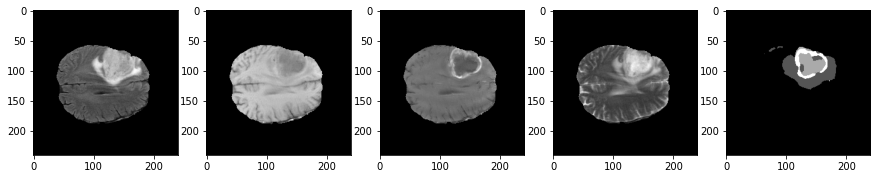

In [108]:
visualize(img, b.squeeze(0))

[0. 1. 2. 3.]


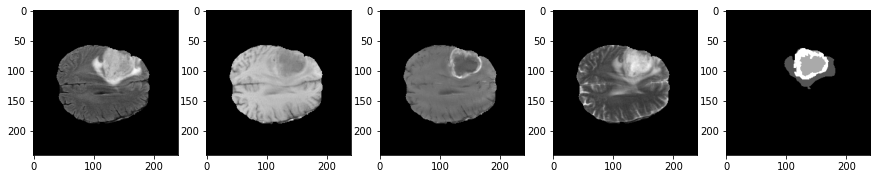

In [109]:
visualize(img, torch.Tensor(target))